In [1]:
import os,sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,average_precision_score,log_loss,brier_score_loss

from sklearn.calibration import calibration_curve

from data.uci.loader import load_uci_data
from data.uci.label_mapper import map_uci_label

from pipelines.train_uci_pipeline import build_uci_gb_pipeline



In [ ]:
#Data Loader
Data_path = "../data/raw/uci/uci_data.xls"
df = load_uci_data(Data_path)
X_raw = df.drop(columns=["ID","default payment next month"],errors="ignore").copy()
y=map_uci_label(df)

In [ ]:
#Train/cal/test split
X_train,X_temp,y_train,y_temp = train_test_split(X_raw,y,test_size=0.30,random_state=42,stratify=y)

In [5]:
X_cal,X_test,y_cal,y_test = train_test_split(X_temp,y_temp,test_size=0.50,random_state=42,stratify=y_temp)

In [6]:
#Fitting the BASE model (uncalibrated) pipeline on train 
base_pipe = build_uci_gb_pipeline(random_state=42)
base_pipe.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature', ...), ('prep', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

In [7]:
p_cal = base_pipe.predict_proba(X_cal)[:,1]
p_test = base_pipe.predict_proba(X_test)[:,1]

In [9]:
print(p_cal[:5])

[0.25036548 0.36179623 0.20449653 0.07706261 0.06685582]


In [10]:
print(p_test[:5])

[0.13431535 0.0637243  0.69982681 0.35573867 0.57959209]



BASE on CAL
ROC-AUC : 0.7618
PR-AUC  : 0.5259
Brier   : 0.1408   (lower better)
LogLoss : 0.4444          (lower better)

BASE on TEST
ROC-AUC : 0.7686
PR-AUC  : 0.5140
Brier   : 0.1408   (lower better)
LogLoss : 0.4429          (lower better)


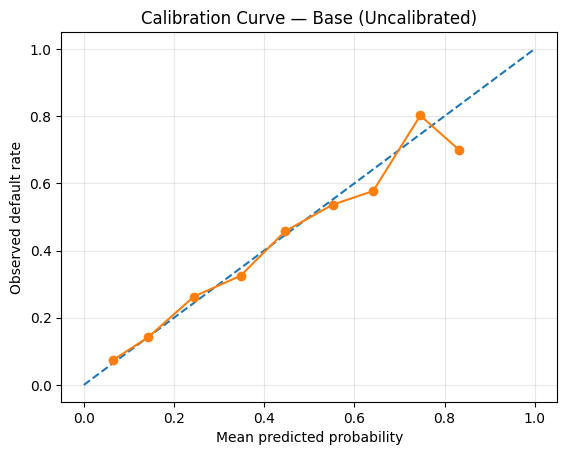

In [ ]:
def show_metrics(name, y_true, p):
    print(f"\n{name}")
    print(f"ROC-AUC : {roc_auc_score(y_true, p):.4f}")
    print(f"PR-AUC  : {average_precision_score(y_true, p):.4f}")
    print(f"Brier   : {brier_score_loss(y_true, p):.4f}   (lower better)")
    print(f"LogLoss : {log_loss(y_true, p):.4f}          (lower better)")

show_metrics("BASE on CAL", y_cal, p_cal)
show_metrics("BASE on TEST", y_test, p_test)


prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="uniform")

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(prob_pred, prob_true, marker="o")
plt.title("Calibration Curve — Base (Uncalibrated)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed default rate")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibration_sigmoid = CalibratedClassifierCV(estimator=base_pipe,method="sigmoid",cv="prefit")
calibration_sigmoid.fit(X_cal,y_cal)